In [52]:
import os
import pandas as pd
import numpy as np
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import zscore
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from distfit import distfit
import pingouin as pg

In [2]:
original_data = pd.read_csv('survey_results.csv', index_col=0)
original_df = df = pd.DataFrame(original_data) 
original_df.head()

,group,id,question,answer,time,confidence,correct_answer,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,faster_timers,slider_timers,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,3,True,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],[],[],16,0,162,0,0,0
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_single_si,1,86,5,1,True,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],[],[],26,8,0,0,0,0
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,3,True,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10,0,23,0,0,10
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_jp,5,605,5,3,False,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],[],[],0,0,100,0,0,0
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,2,True,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],[],[],0,0,10,0,0,0


In [3]:
wrong_answers = ['0d215911-e63c-46ad-a063-653b709f8253',
'037605fd-b893-4885-b04a-8e9c2bed8a1a',
'1039ad57-5293-4af8-acce-89edd244cc7a',
'86bfd834-db2c-44ee-8300-8f182be02533',
'224c8817-b026-4280-b546-04d6cb5388f7',
'2e4f721a-71de-465c-97c1-4bd8a4c7a5d4',
'ffadb36b-5051-4684-b9cf-ed767a599434',
'f357cda5-2402-4fd5-93ff-d8d6ed2a566d']

In [4]:
# remove id's who answered control questions 2&3 wrong
original_df = original_df[~original_df['id'].isin(wrong_answers)]

In [5]:
#filter control questions out
control_questions = ['control1', 'control2', 'control3']
original_df = original_df[~original_df['question'].isin(control_questions)]


original_df['network_enc'] = original_df['question'].str.split('_').str[0]
original_df['task_type'] = original_df['question'].str.split('_').str[1]
original_df['task_entity'] = original_df['question'].str.split('_').str[2]
original_df['temporal_enc'] = original_df['question'].str.split('_').str[3]
original_df['correct'] = original_df['correct'].apply(str).str.lower()
original_df['time'] = original_df['time'].apply(int)

original_df = original_df.drop(['question', 'id', 'correct_answer'], axis=1)
original_df.head()

,group,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,faster_timers,...,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc
0,B,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],[],...,16,0,162,0,0,0,m,t1,clique,si
1,B,1,86,5,true,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],[],...,26,8,0,0,0,0,nl,t3,single,si
2,B,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],[],...,10,0,23,0,0,10,m,t1,single,tl
3,B,5,605,5,false,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],[],...,0,0,100,0,0,0,m,t3,clique,jp
4,B,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],[],...,0,0,10,0,0,0,m,t1,single,si


## Functions

In [6]:
def shapiro_wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [7]:
def levene_test(arr1, arr2, arr3, arr4, center):
    stat, p = levene(arr1, arr2, arr3, arr4, center=center)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

In [8]:
def test_distribution(time_orig, time_trans):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    prob = probplot(time_orig, dist=norm, plot=ax1)
    prob = probplot(time_trans, dist=norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('Time Taken')
    ax2.set_title('Transformed Data, λ = %s' % -0.322);
    ax2.set_ylabel('');

In [9]:
def box_cox(df):
    df_trans, lmbda = boxcox(df)
    return df_trans

In [10]:
def remove_outlier_IQR(df, col, lower, upper):
    Q1=df[col].quantile(lower/100)
    Q3=df[col].quantile(upper/100)
    IQR=Q3-Q1
    
    df_final=df[~((df[col]<(Q1-1.5*IQR)) | (df[col]>(Q3+1.5*IQR)))]
    return df_final

In [11]:
def plot_hist(data):
    pyplot.hist(data, bins="sqrt")

In [12]:
def transform_data(df):
    df['time_trans'] = box_cox(df['time'])
    test_distribution(df['time'], df['time_trans'])

    shapiro_wilk(df['time_trans'])

In [13]:
def check_dist(df):
    dist = distfit(alpha=0.05, stats='RSS')
    dist.fit_transform(df,verbose=1)
    dist.plot(verbose=1)
    dist.summary

In [67]:
def box_plot(df):
    sns.boxplot(x=df)

## H1

In [14]:
# step 1: create data groups (nl vs m)
h1_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h1_m_df = original_df.loc[original_df['network_enc'] == 'm']

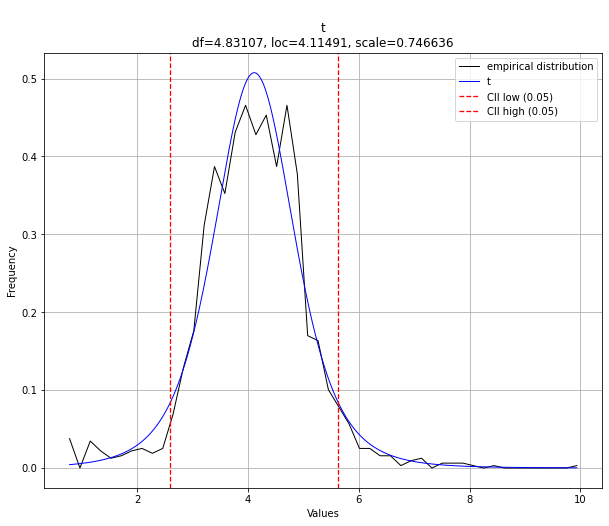

In [15]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df['time']))

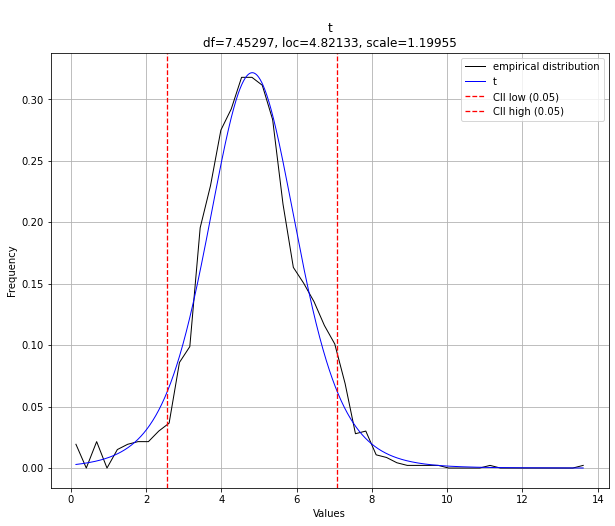

In [16]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df['time']))

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


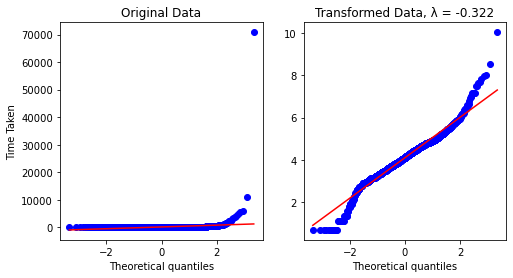

In [17]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


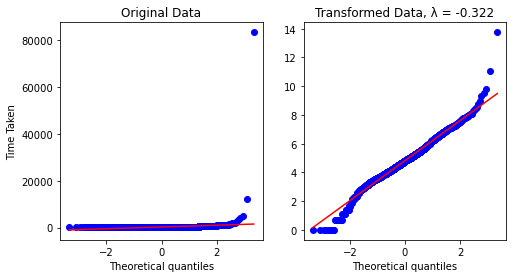

In [18]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df)

Statistics=0.998, p=0.018
Sample does not look Gaussian (reject H0)


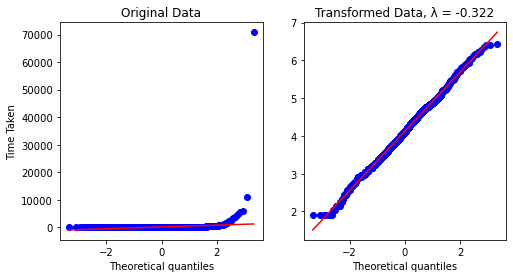

In [76]:
# step 4: IQR outlier removal
h1_nl_df_cleansed = remove_outlier_IQR(h1_nl_df, 'time_trans', 25, 75)
test_distribution(h1_nl_df['time'], h1_nl_df_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_cleansed['time_trans'])

Statistics=0.995, p=0.000
Sample does not look Gaussian (reject H0)


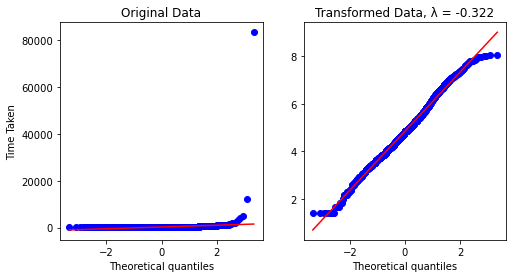

In [77]:
# step 4: IQR outlier removal
h1_m_df_cleansed = remove_outlier_IQR(h1_m_df, 'time_trans', 25, 75)
test_distribution(h1_m_df['time'], h1_m_df_cleansed['time_trans'])
shapiro_wilk(h1_m_df_cleansed['time_trans'])

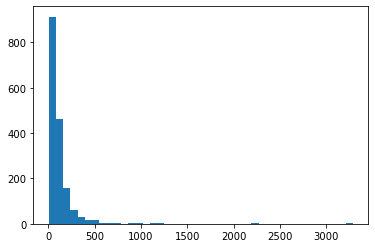

In [21]:
plot_hist(h1_nl_df_cleansed['time'])

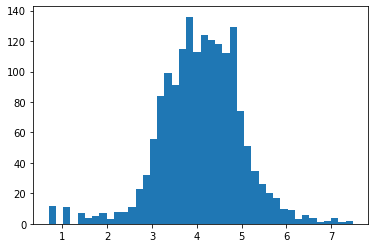

In [22]:
plot_hist(h1_nl_df_cleansed['time_trans'])

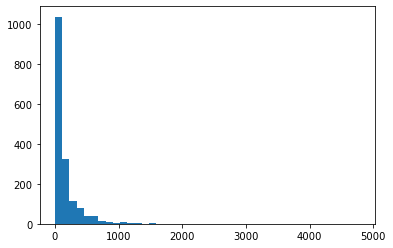

In [23]:
plot_hist(h1_m_df_cleansed['time'])

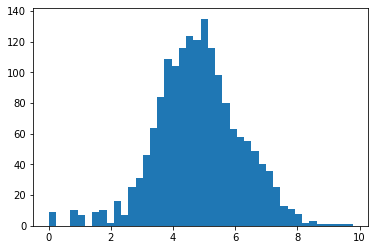

In [24]:
plot_hist(h1_m_df_cleansed['time_trans'])

In [78]:
# step 5: further subdivide based on task type
# nl vs m for t1
h1_nl_df_t1 = h1_nl_df_cleansed.loc[h1_nl_df_cleansed['task_type'] == 't1']
h1_m_df_t1 = h1_m_df_cleansed.loc[h1_m_df_cleansed['task_type'] == 't1']

# nl vs m for t2
h1_nl_df_t2 = h1_nl_df_cleansed.loc[h1_nl_df_cleansed['task_type'] == 't2']
h1_m_df_t2 = h1_m_df_cleansed.loc[h1_m_df_cleansed['task_type'] == 't2']

# nl vs m for t3
h1_nl_df_t3 = h1_nl_df_cleansed.loc[h1_nl_df_cleansed['task_type'] == 't3']
h1_m_df_t3 = h1_m_df_cleansed.loc[h1_m_df_cleansed['task_type'] == 't3']

In [26]:
friedmanchisquare(original_df['time'], h1_nl_df_t2['time_trans'], h1_nl_df_t3['time_trans'])

ValueError: Unequal N in friedmanchisquare.  Aborting.

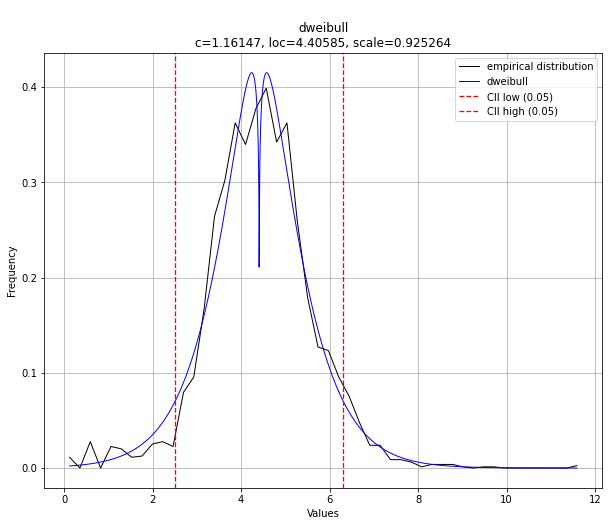

In [40]:
check_dist(box_cox(original_df['time']))

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)


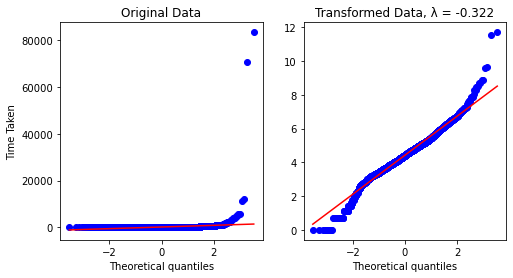

In [41]:
transform_data(original_df)

Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


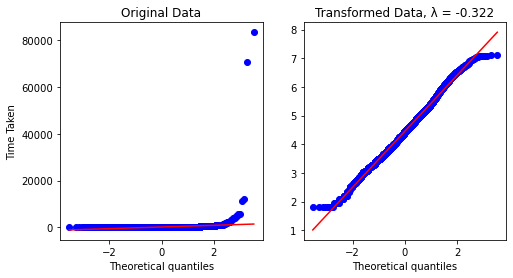

In [79]:
# step 4: IQR outlier removal
original_df_cleansed = remove_outlier_IQR(original_df, 'time_trans', 25, 75)
test_distribution(original_df['time'], original_df_cleansed['time_trans'])
shapiro_wilk(original_df_cleansed['time_trans'])

In [46]:
# # check if nl vs m is different
pg.friedman(data=original_df, dv="time_trans", within="network_enc", subject="task_type", method="chisq")

,Source,W,ddof1,Q,p-unc
Friedman,network_enc,1.0,1,3.0,0.083265


In [ ]:
# check if tasks are different in nl and m
pg.friedman(data=h1_nl_df, dv="time_trans", within="task_type")

In [ ]:
friedman(data=h1_m_df, dv="time_trans", within="task_type")

In [71]:
# H0: NL[time] === M[time]
# H1: NL[time] !== M[time]
mannwhitneyu(h1_nl_df['time'], h1_m_df['time'], alternative="two-sided") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=1309116.0, pvalue=4.609345345004485e-06)

In [72]:
mannwhitneyu(h1_nl_df_t1['time'], h1_m_df_t1['time'], alternative="two-sided") # ~0.014-> reject? << 0.05 -> reject H0

MannwhitneyuResult(statistic=146048.5, pvalue=0.013454838485222874)

In [73]:
# H0 NL_T1[time] >= M_T1[time]
# H1.1 NL_T1[time] < M_T1[time]
mannwhitneyu(h1_nl_df_t1['time'], h1_m_df_t1['time'], alternative="less") # 0.006867247155202645 -> reject?

MannwhitneyuResult(statistic=146048.5, pvalue=0.006727419242611437)

<AxesSubplot:xlabel='time', ylabel='network_enc'>

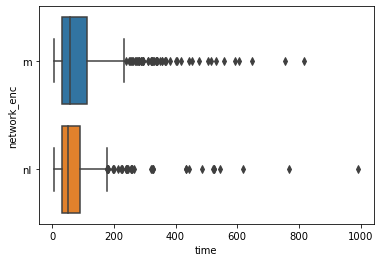

In [96]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't1'])

<AxesSubplot:xlabel='correct', ylabel='count'>

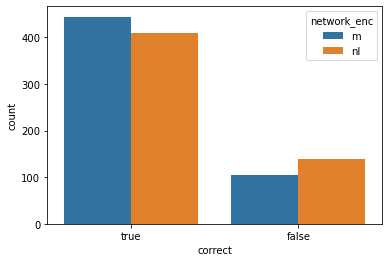

In [95]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't1'])

<AxesSubplot:xlabel='time', ylabel='network_enc'>

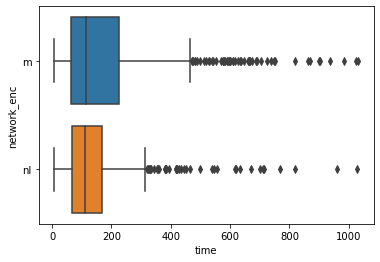

In [86]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't2'])

<AxesSubplot:xlabel='correct', ylabel='count'>

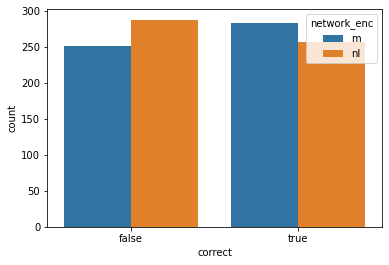

In [97]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't2'])

<AxesSubplot:xlabel='time', ylabel='network_enc'>

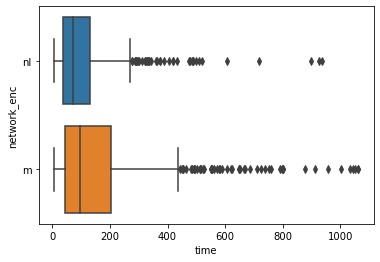

In [87]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't3'])

<AxesSubplot:xlabel='correct', ylabel='count'>

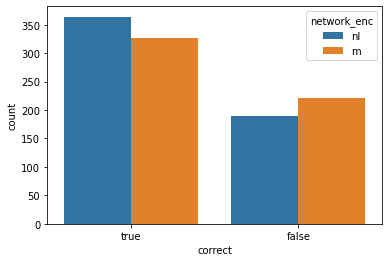

In [98]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't3'])

In [63]:
# H0 NL_T2[time] >= M_T2[time]
# H1.2 NL_T2[time] < M_T2[time]
mannwhitneyu(h1_nl_df_t2['time'], h1_m_df_t2['time'], alternative="less") # 0.16509464970518734 -> approve?

MannwhitneyuResult(statistic=154540.5, pvalue=0.16509464970518734)

In [64]:
# H0 NL_T3[time] >= M_T3[time]
# H1.3 NL_T3[time] < M_T3[time]
mannwhitneyu(h1_nl_df_t3['time'], h1_m_df_t3['time'], alternative="less") # 6.178450282400558e-07 -> reject?

MannwhitneyuResult(statistic=133248.5, pvalue=6.178450282400558e-07)

In [53]:
print(len(h1_nl_df['time_trans']), len(h1_m_df['time_trans']))

1701 1693


## H2

In [ ]:
# step 1: create data groups (si vs jp vs tl vs an)
h2_si_df = original_df.loc[original_df['temporal_enc'] == 'si']
h2_jp_df = original_df.loc[original_df['temporal_enc'] == 'jp']
h2_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h2_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h2_si_df['time']))

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h2_jp_df['time']))

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h2_tl_df['time']))

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h2_an_df['time']))

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h2_si_df)

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h2_jp_df)

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h2_tl_df)

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h2_an_df)

In [ ]:
# step 4: IQR outlier removal
h2_si_df_cleansed = remove_outlier_IQR(h2_si_df, 'time_trans', 15, 85)
test_distribution(h2_si_df['time'], h2_si_df_cleansed['time_trans'])
shapiro_wilk(h2_si_df_cleansed['time_trans'])

In [ ]:
# step 4: IQR outlier removal
h2_jp_df_cleansed = remove_outlier_IQR(h2_jp_df, 'time_trans', 15, 85)
test_distribution(h2_jp_df['time'], h2_jp_df_cleansed['time_trans'])
shapiro_wilk(h2_jp_df_cleansed['time_trans'])

In [ ]:
# step 4: IQR outlier removal
h2_tl_df_cleansed = remove_outlier_IQR(h2_tl_df, 'time_trans', 15, 85)
test_distribution(h2_tl_df['time'], h2_tl_df_cleansed['time_trans'])
shapiro_wilk(h2_tl_df_cleansed['time_trans'])

In [ ]:
# step 4: IQR outlier removal
h2_an_df_cleansed = remove_outlier_IQR(h2_an_df, 'time_trans', 15, 85)
test_distribution(h2_an_df['time'], h2_an_df_cleansed['time_trans'])
shapiro_wilk(h2_an_df_cleansed['time_trans'])

## H3

In [ ]:
# step 1: create data groups (tl vs an)
h3_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h3_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h3_tl_df['time']))

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h3_an_df['time']))

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h3_tl_df)

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h3_an_df)

In [ ]:
# step 4: IQR outlier removal
h3_tl_df_cleansed = remove_outlier_IQR(h3_tl_df, 'time_trans', 15, 85)
test_distribution(h3_tl_df['time'], h3_tl_df_cleansed['time_trans'])
shapiro_wilk(h3_tl_df_cleansed['time_trans'])

In [ ]:
# step 4: IQR outlier removal
h3_an_df_cleansed = remove_outlier_IQR(h3_an_df, 'time_trans', 15, 85)
test_distribution(h3_an_df['time'], h3_an_df_cleansed['time_trans'])
shapiro_wilk(h3_an_df_cleansed['time_trans'])

## H4

In [ ]:
# step 1: create data groups (a vs b)
h4_a_df = original_df.loc[original_df['group'] == 'A']
h4_b_df = original_df.loc[original_df['group'] == 'B']

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h4_a_df['time']))

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h4_b_df['time']))

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h4_a_df)

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h4_b_df)

In [ ]:
# step 4: IQR outlier removal
h4_a_df_cleansed = remove_outlier_IQR(h4_a_df, 'time_trans', 15, 85)
test_distribution(h4_a_df['time'], h4_a_df_cleansed['time_trans'])
shapiro_wilk(h4_a_df_cleansed['time_trans'])

In [ ]:
# step 4: IQR outlier removal
h4_b_df_cleansed = remove_outlier_IQR(h4_b_df, 'time_trans', 15, 85)
test_distribution(h4_b_df['time'], h4_b_df_cleansed['time_trans'])
shapiro_wilk(h4_b_df_cleansed['time_trans'])

## H5

In [ ]:
# step 1: create data groups (tl vs an)
h5_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h5_m_df = original_df.loc[original_df['network_enc'] == 'm']

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h5_nl_df['time']))

In [ ]:
# step 2: check data distribution
check_dist(box_cox(h5_m_df['time']))

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h5_nl_df)

In [ ]:
# step 3: transform using box cox and compare before and after
transform_data(h5_m_df)

In [ ]:
# step 4: IQR outlier removal
h5_nl_df_cleansed = remove_outlier_IQR(h5_nl_df, 'time_trans', 15, 85)
test_distribution(h5_nl_df['time'], h5_nl_df_cleansed['time_trans'])
shapiro_wilk(h5_nl_df_cleansed['time_trans'])

In [ ]:
# step 4: IQR outlier removal
h5_m_df_cleansed = remove_outlier_IQR(h5_m_df, 'time_trans', 15, 85)
test_distribution(h5_m_df['time'], h5_m_df_cleansed['time_trans'])
shapiro_wilk(h5_m_df_cleansed['time_trans'])

In [ ]:
# step 5: further subdivide based on task type
# single vs clique for nl
h5_nl_single_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'single']
h5_nl_clique_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'clique']

# single vs clique for m
h5_m_single_df = h5_m_df.loc[h5_m_df['task_entity'] == 'single']
h5_m_clique_df = h5_m_df.loc[h5_m_df['task_entity'] == 'clique']

## H6